# Find owners of parcels by categories and plot #

Find category of owners of all parcels with wish list csv file

# Impot libraries #

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import sqlite3
import numpy as np

# Defintion of the files #

## Shapefiles Parcelles ##

In [2]:
# Data files
# Shapefiles

file_NPCS_PARV = "../data/shapefiles/NPCS_CAD_TPR_PARV_S.shp"
file_MOVD_PARV= "../data/shapefiles/MOVD_CAD_TPR_PARV_S.shp"

## Other data ##

In [3]:
# Other data

file_communes_vd = '../data/communes_vd.csv'
file_whish_list = '../data/mex_whish_list.csv'

# DB connexion #

In [4]:
db_file = '../data/APMK.sqlite'
con = sqlite3.connect(db_file)

# Load parcels data #

In [5]:
# Load shapefile to geodataframe and merge them

parcels_NPCS_PARV = gpd.read_file(file_NPCS_PARV)
parcels_MOVD_PARV = gpd.read_file(file_MOVD_PARV)

## Merge parcels dataframe ##

In [6]:
parcels_shape = pd.concat([parcels_NPCS_PARV, parcels_MOVD_PARV])
parcels_shape.reset_index(drop=True, inplace=True)

In [7]:
parcels_shape = parcels_shape.drop(['VALIDITE_T', 'VALIDITE', 'EGRIS_EGRI', 'ID', 'SHAPE_LEN', 'INTEGRALIT', 'IDENTDN', 'SUPERFICIE', 'SHAPE_AREA', 'GENRE_TXT', 'GENRE'], axis=1)

# Import data of communes of Vaud #

In [8]:
communes_vd_data = pd.read_csv(file_communes_vd)
# cleanup
communes_vd_data = communes_vd_data[['no_com_can', 'no_com_fed', 'nom_min', 'perimetre']]
communes_vd_data = communes_vd_data.rename(columns={"no_com_can": "no_com", "nom_min": "nom_commune"})
communes_vd_data['nom_commune'] = communes_vd_data['nom_commune'].str.replace(' (VD)', '', regex=False)

## Load which list of parcelles ##

In [9]:
# Load list of parcels sought and add columns

whish_list = pd.read_csv(file_whish_list)

## build IDEX2000 value ##

In [10]:
# Add new columns

whish_list['IDEX2000'] = whish_list['no_com'].map('{:0>3}'.format) + whish_list['no_parc'].map('{:0>6}'.format)
whish_list['IDEX2000'] = np.int64(whish_list['IDEX2000'])

## build ficheID ##

In [11]:
whish_list['fiche_id'] = whish_list['no_com'].map(str) + "." + whish_list['no_parc'].map(str)

## Add column no_com ##

In [12]:
whish_list = pd.merge(whish_list, communes_vd_data, how='left', on='no_com')

## Clean dataframe ##

In [13]:
# Fix values column proprietaire

whish_list.proprietaire = whish_list.proprietaire.str.replace(' [Ll]a [cC]ommune[, ]*.*', '', regex=True)
whish_list.proprietaire = whish_list.proprietaire.str.replace('St-', 'Saint-', regex=True)
whish_list.proprietaire = whish_list.proprietaire.str.replace(' s/', '-sur-', regex=True)

## Convert whish_list dataframe to geodataframe ##

In [14]:
# Convert which_list to Geodataframe

whish_list = gpd.GeoDataFrame(whish_list)
whish_list['geometry'] = None
whish_list = whish_list.set_crs(crs=2056)
whish_list = whish_list.drop(['geometry'], axis=1)
whish_list = pd.merge(whish_list, parcels_shape, how='left', on='IDEX2000')
whish_list = whish_list.drop(['NUMERO'], axis=1)
whish_list['centroid'] = whish_list.centroid

-----

# Definition of categories of owners #
code : 1 = commune 2 = confédération 3 = état 4 = autre

In [15]:
# Define catageries of owners
# code : 1 = commune 2 = confédération 3 = état 4 = autre

whish_list['code_owner'] = None
for index, row in whish_list.iterrows():
    if row['nom_commune'] == row['proprietaire'].split(" ", 1)[0]:
        whish_list.at[index,'code_owner'] = 1
    elif row['proprietaire'].split(" ", 1)[0] == "Confédération":
        whish_list.at[index,'code_owner'] = 2
    elif row['proprietaire'].split(" ", 1)[0] == "Etat":
        whish_list.at[index,'code_owner'] = 3
    else:
        whish_list.at[index,'code_owner'] = 4

# Find neighbors #

In [18]:
# Find neighbors

whish_list['neighbors'] = None

for index, row in whish_list.iterrows():
    if not row['geometry'] == None:
        whish_list.at[index, 'neighbors'] = whish_list[whish_list.geometry.touches(row['geometry'])].no_parc.tolist()

# Plot map #

posx and posy should be finite values
posx and posy should be finite values


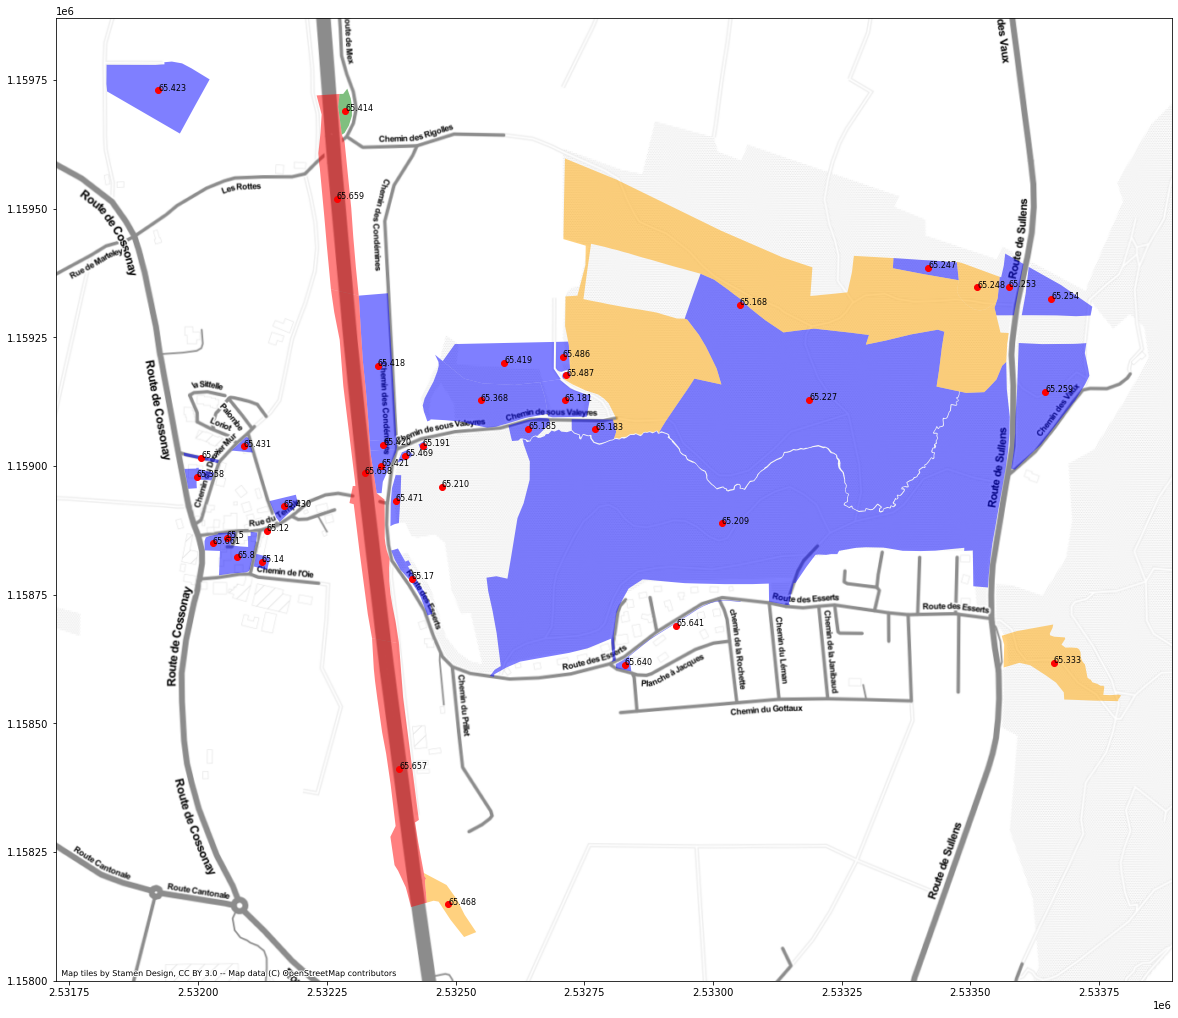

In [20]:
# Define layers

layers = []
layers.append({'layer' : 'com', 'geom' : whish_list.loc[whish_list['code_owner']==1], 'color' : 'blue'})
layers.append({'layer' : 'conf', 'geom' : whish_list.loc[whish_list['code_owner']==2], 'color' : 'red'})
layers.append({'layer' : 'etat', 'geom' : whish_list.loc[whish_list['code_owner']==3], 'color' : 'green'})
layers.append({'layer' : 'autre', 'geom' : whish_list.loc[whish_list['code_owner']==4], 'color' : 'orange'})

alpha_value = 0.5

fig, ax = plt.subplots(figsize=(10,10))
for row in layers:
    row['geom']['geometry'].plot(ax=ax, facecolor=row['color'], alpha=alpha_value)

whish_list['centroid'].plot(ax=ax, facecolor='red')
cx.add_basemap(ax=ax, crs=2056, source=cx.providers.Stamen.TonerLite)

#for x, y, label in zip(whish_list['centroid'].x, whish_list['centroid'].y, whish_list['fiche_id']):
#    plt.text(x, y, label, fontsize = 8)

# Export layers to shapefiles #

In [ ]:
prefix_file_name = str(layers[0]['geom']['no_com'][0])

for row in layers:
    if not row['geom'].empty:
        gdf_tf = row['geom'].drop(['centroid'], axis=1)
        gdf_tf.to_file("../data/" + prefix_file_name + "_" + row['layer'] + ".shp")
        
cent_tf = gpd.GeoDataFrame(whish_list[['fiche_id', 'centroid']])
cent_tf = cent_tf.rename(columns={"centroid": "geometry"})
cent_tf.to_file("../data/" + prefix_file_name + "_cent.shp")

# Export centroid to csv file #

In [ ]:
centroid = whish_list[['fiche_id', 'centroid']]

In [ ]:
centroid_file = open('../data/centroid.csv', 'w') 
for index, row in centroid.iterrows():
    if row['centroid'] is not None:
        v = "'" + str(row['fiche_id']) + "'," + str(round(row['centroid'].x, 3)) + "," + str(round(row['centroid'].y, 3)) + "\n"
        centroid_file.write(v)
        #print(v)
centroid_file.close() 

-----

# Tests zone #

In [22]:
whish_list.head()

,no_com,no_parc,proprietaire,IDEX2000,fiche_id,no_com_fed,nom_commune,perimetre,geometry,centroid,code_owner,neighbors
0,65,5,Mex,65000005,65.5,5489,Mex,1.0,"POLYGON ((2532061.341 1158846.223, 2532051.441...",POINT (2532055.976 1158860.032),1,"[8, 661]"
1,65,7,Mex,65000007,65.7,5489,Mex,1.0,"POLYGON ((2532038.371 1159005.755, 2532013.881...",POINT (2532006.058 1159015.739),1,[]
2,65,8,Mex,65000008,65.8,5489,Mex,1.0,"POLYGON ((2532040.587 1158787.629, 2532042.393...",POINT (2532075.950 1158822.906),1,"[5, 661]"
3,65,12,Mex,65000012,65.12,5489,Mex,1.0,"POLYGON ((2532138.062 1158877.133, 2532136.182...",POINT (2532133.191 1158873.769),1,[]
4,65,14,Mex,65000014,65.14,5489,Mex,1.0,"POLYGON ((2532108.006 1158804.667, 2532109.331...",POINT (2532123.746 1158813.701),1,[]


In [25]:
layers

[{'layer': 'com',
  'geom':     no_com  no_parc proprietaire  IDEX2000 fiche_id  no_com_fed nom_commune  \
  0       65        5          Mex  65000005     65.5        5489         Mex   
  1       65        7          Mex  65000007     65.7        5489         Mex   
  2       65        8          Mex  65000008     65.8        5489         Mex   
  3       65       12          Mex  65000012    65.12        5489         Mex   
  4       65       14          Mex  65000014    65.14        5489         Mex   
  5       65       17          Mex  65000017    65.17        5489         Mex   
  7       65      181          Mex  65000181   65.181        5489         Mex   
  8       65      183          Mex  65000183   65.183        5489         Mex   
  9       65      185          Mex  65000185   65.185        5489         Mex   
  10      65      191          Mex  65000191   65.191        5489         Mex   
  11      65      209          Mex  65000209   65.209        5489         Mex   
  